# CODE (Lecture 11) - 11 January / 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp
import networkx as nx
import math
import random
import collections
from numpy import linalg as la

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



### Integrators

In [2]:
def rk4s(f,h,x,**kwargs): # RK4 single iteration
    k1 = h*f(x,**kwargs)
    k2 = h*f(x+0.5*k1,**kwargs)
    k3 = h*f(x+0.5*k2,**kwargs)
    k4 = h*f(x+k3,**kwargs)
    x += (k1+2*k2+2*k3+k4)/6
    return x 

### Lorenz System

In [3]:
def Lorenz(y, t=0, sigma=10, rho=28, beta=2.6667):
    dy = np.zeros_like(y)
    dy[0] = sigma * (y[1]-y[0])
    dy[1] = y[0] *(rho-y[2])- y[1]
    dy[2] = y[0]*y[1] - beta*y[2]
    return dy

## Networks

In [4]:
def RandomGraph(N, p):
    A = np.zeros(shape=(N,N))
    for i in range(0,N):
        for j in range(0,i):
            if (random.random() < p):
                A[i,j], A[j,i] = 1,1           
    return A

def Ring(N, k=1):
    A = np.zeros(shape=(N,N))
    for i in range(0,N):
        for j in range(1,k+1):
            A[i,(i+j)%N],A[(i+j)%N,i] = 1,1
            A[i,(i-j)%N],A[(i-j)%N,i] = 1,1
    return A

def WSGraph (N, k, beta):
    A = Ring(N, k)
    for i in range(N):
        for j in range(N):
            if ((A[i,j]) and (random.random()<beta)):
                A[i,i] = 1
                new = random.choice(np.where(A[i,:] == 0)[0])
                A[i,new], A[new,i] = 1, 1
                A[i,j], A[j,i], A[i,i] = 0, 0, 0
    return A

def makeGraph(A, layout=nx.spring_layout):
    G = nx.from_numpy_array(A)
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    nx.draw(G, layout(G), node_size=70)
    plt.subplot(122)
    degree_sequence = sorted([d for n,d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg,cnt = zip(*degreeCount.items())
    plt.bar(deg,cnt,width=0.6,color='r')

    plt.show()
    return G

def Laplacian(A):
    L = np.copy(A)
    for i in range(len(L)):
        L[i,i] = -np.sum(L[i,:])
    return -L

## Network Dynamics



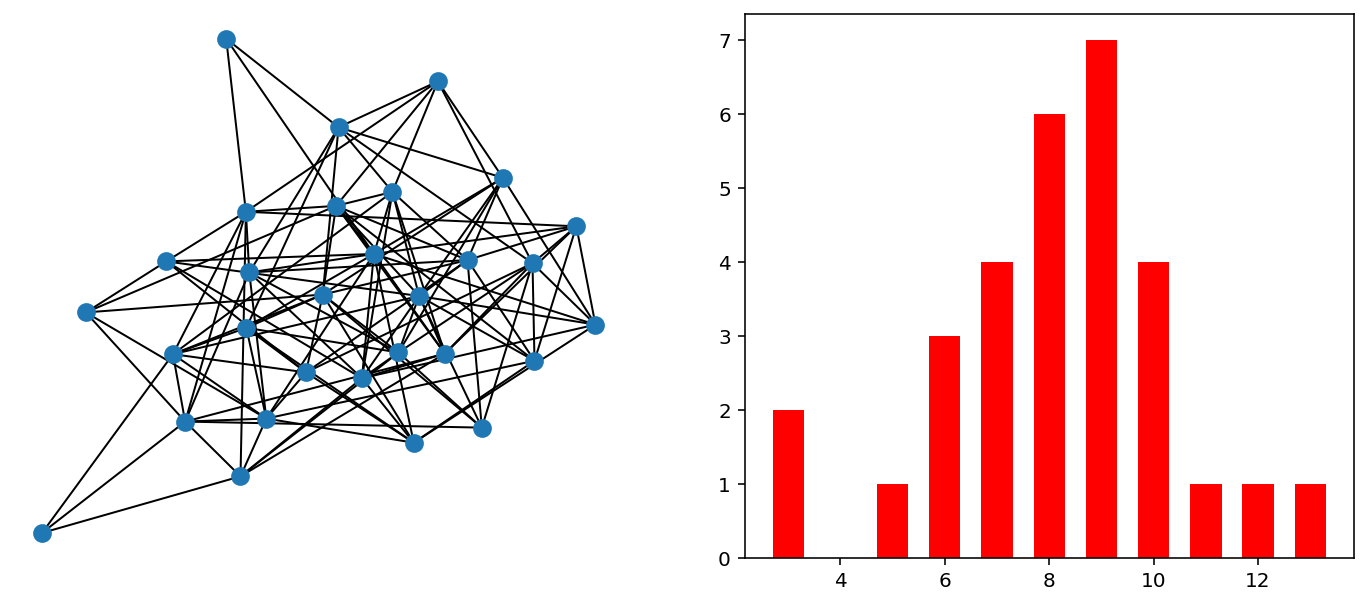

Graph Connected
Spectral Gap (L):  2.346339876356277


In [5]:
N = 30
A = RandomGraph(N,0.3)
L = Laplacian(A)
G = makeGraph(A, layout=nx.spring_layout)

if nx.is_connected(G):
    print('Graph Connected')
    SG = EigenSorted = np.sort(la.eigvals(L))[1]
    print('Spectral Gap (L): ',SG) 
else:
    print('Graph not Connected')


In [6]:
def MultiLorenz(y, t=0, N=1, sigma=10, rho=28, beta=2.6667):
    dy = np.zeros(shape=(N,3))
    for i in range(N):
        dy[i,0] = sigma * (y[i,1]-y[i,0])
        dy[i,1] = y[i,0] *(rho-y[i,2])- y[i,1]
        dy[i,2] = y[i,0]*y[i,1] - beta*y[i,2]
    return dy

def NetworkDynamics(x, alpha=0, N=1, H=np.eye(3), L=None):
    Hu = np.array([list(map(lambda l:H.dot(l),x[np.arange(N)]))]).squeeze()
    #print(Hu)
    return MultiLorenz(x, N=N) - alpha*L.dot(Hu)

ALPHA CRITICAL : 0.39210005731509967
ALPHA = 0.3
0 > 1 > 2 > 3 > 4 > 5 > 6 > 7 > 8 > 9 > 

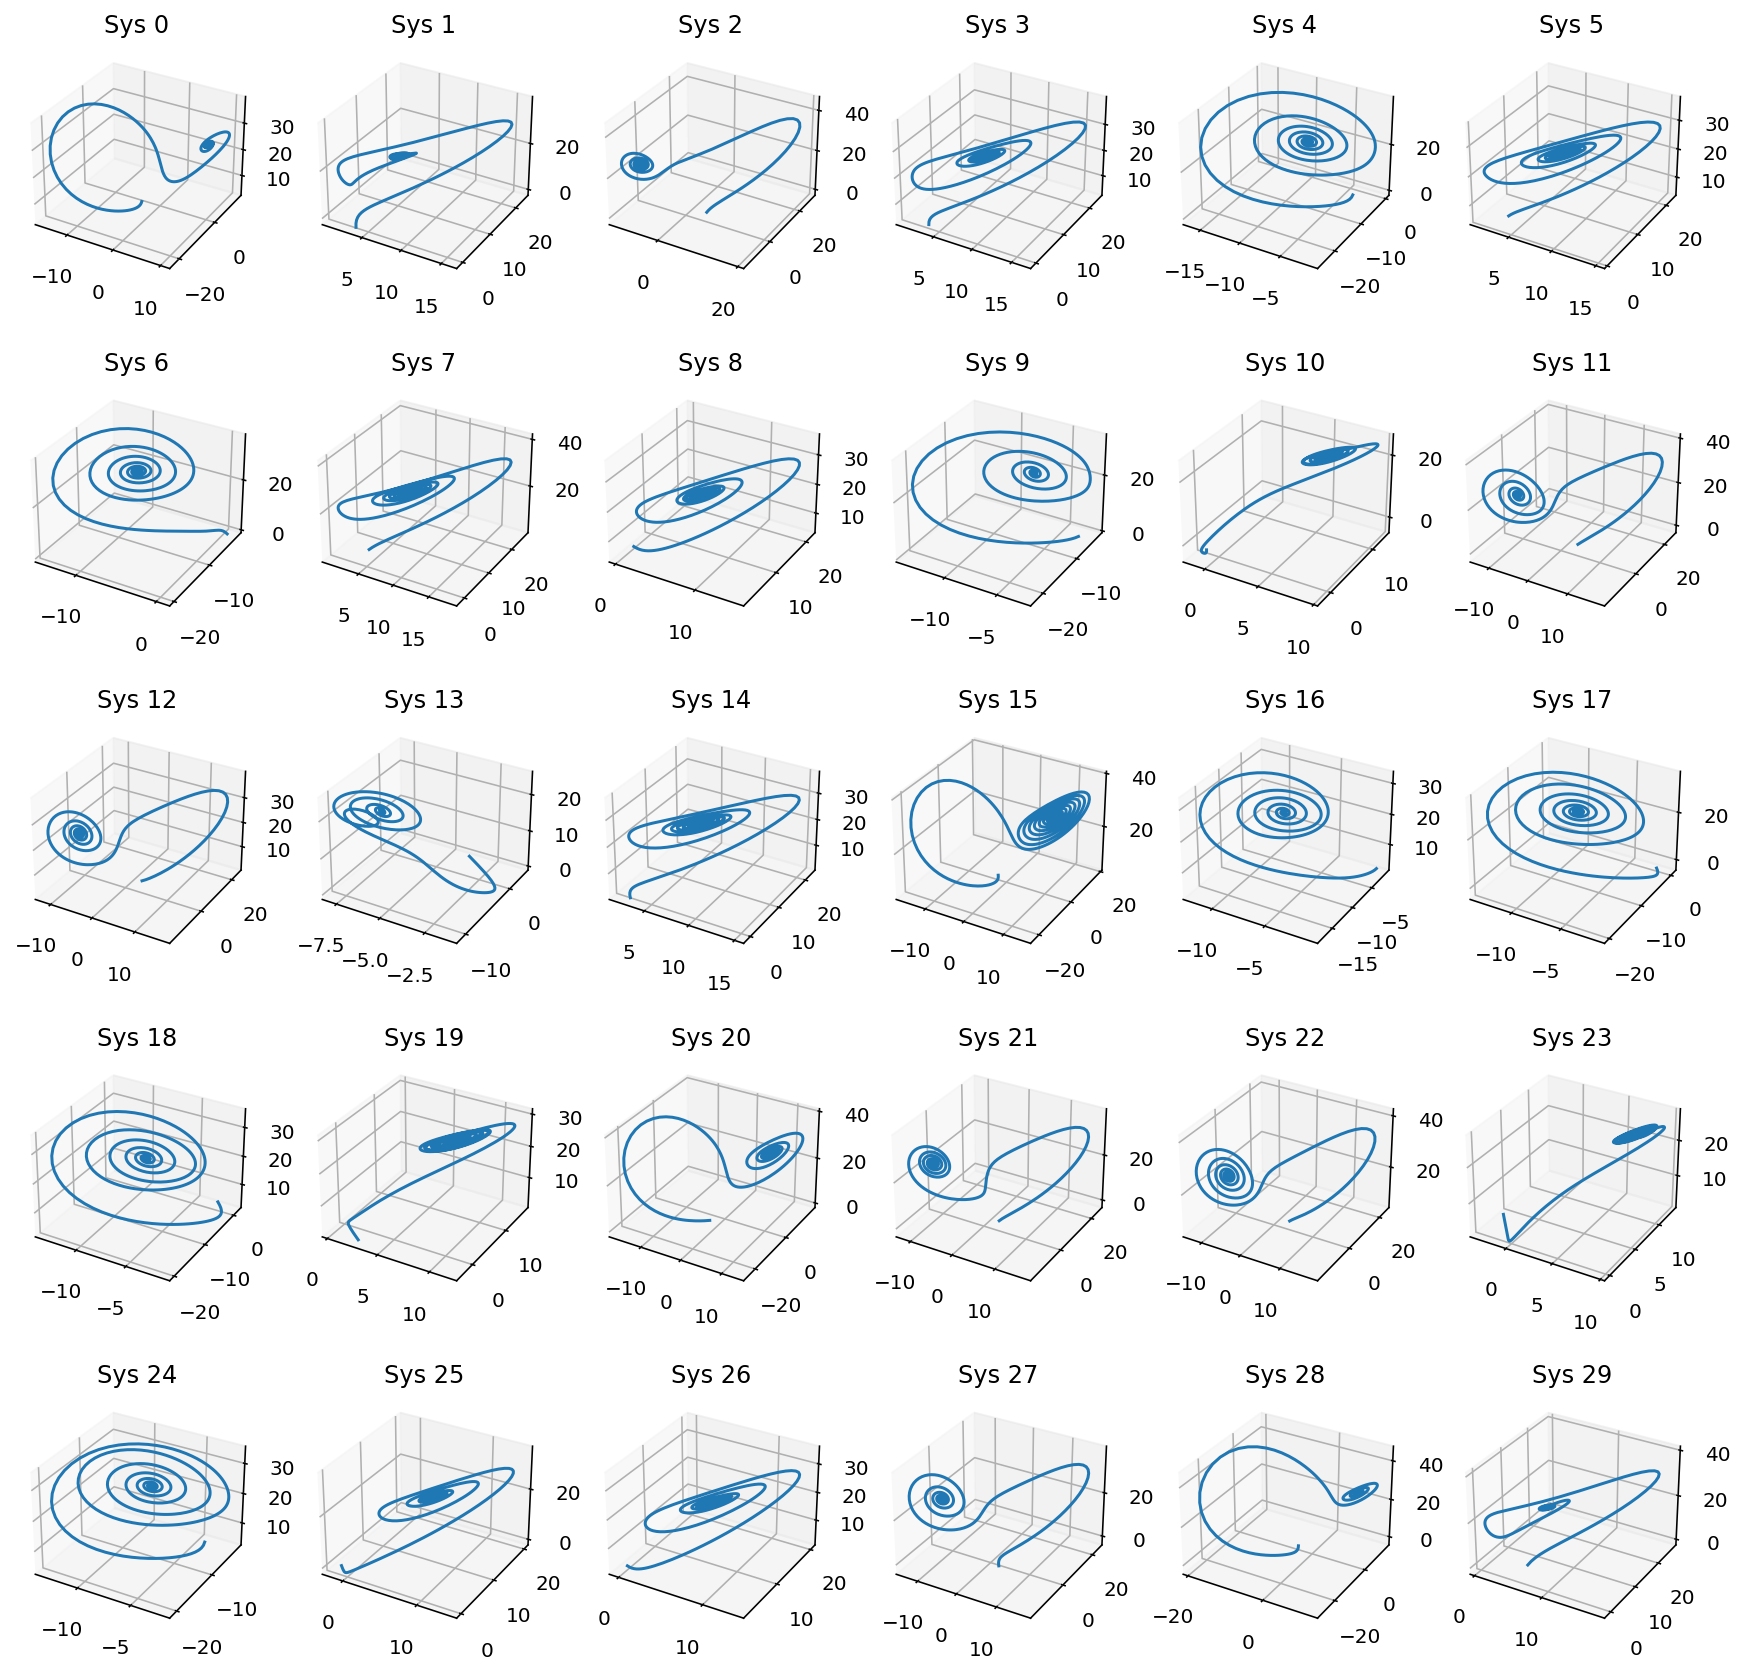

In [8]:
MaxLya = 0.92
alpha = 0.3
print('ALPHA CRITICAL :',MaxLya / SG)
print('ALPHA =',alpha)

Dim = 3 
H = np.eye(Dim)

x_start = np.random.uniform(-5,5,[N,Dim])

#Set timeline
t_init = 0
t_step = 0.01
steps = 15000
t_final = t_init + steps*t_step
timeline = np.arange(t_init,t_final,t_step)

x = np.zeros([N,Dim,steps])
x[:,:,0] = x_start

for i in range(steps-1):
    x[:,:,i+1] = rk4s(NetworkDynamics, t_step, x[:,:,i], N=N, H=H, L=L, alpha=alpha)
    if i%math.floor(steps/10)==0: print(int(10*i/steps),end=' > ')
        
plt.figure(figsize=(15, 3*math.ceil(N/6)))
for i in range(N):
    plt.subplot(math.ceil(N/6),6, i+1, projection='3d', title='Sys %d'%i)
    plt.plot(x[i,0,:],x[i,1,:],x[i,2,:])
    
    

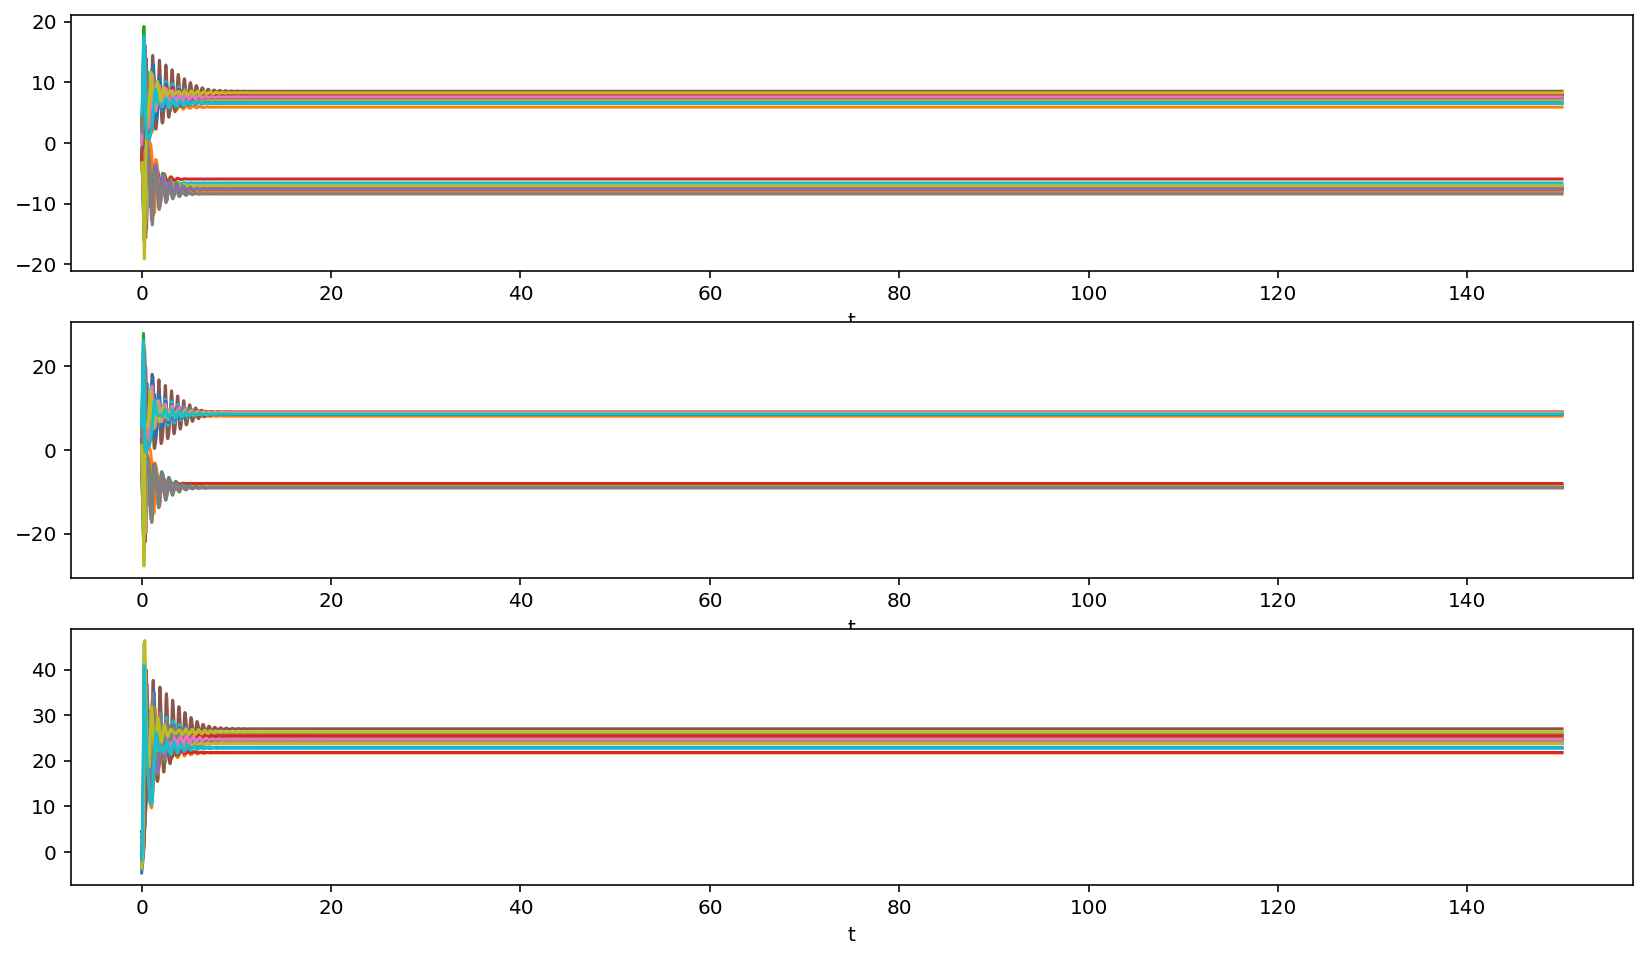

In [9]:
components = ['x','y','z']
plt.figure(figsize=(14,8))
for i in range(Dim):
    plt.subplot(Dim,1,i+1)
    for k in range(N):
        plt.plot(timeline, x[k,i,:])
    plt.xlabel('t')
    plt.ylabel=(components[i])
plt.show()

### Synchronization Error

0 > 1 > 2 > 3 > 4 > 5 > 6 > 7 > 8 > 9 > 

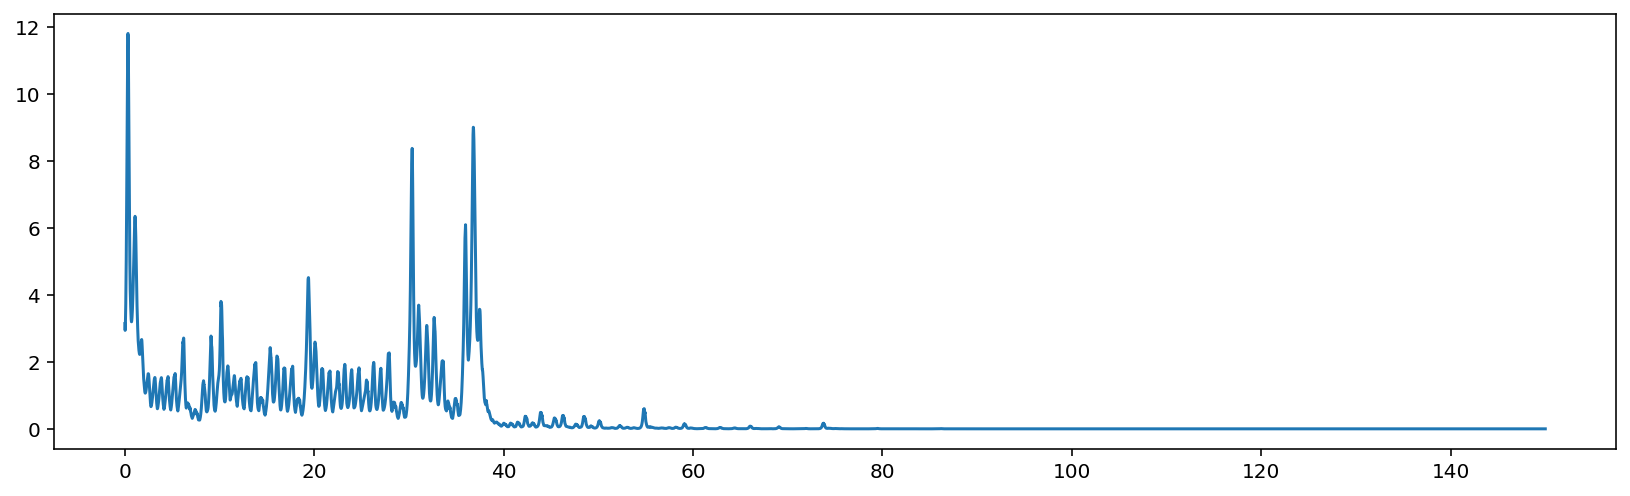

In [130]:
SyncError = np.zeros(steps)
Normalizer = 2 / (Dim*N*(N-1))
for t in range(steps):
    if t%math.floor(steps/10)==0: print(int(10*t/steps),end=' > ')
    for i in range(N):
        for j in range(i):
            for k in range(Dim):
                SyncError[t] += Normalizer * abs(x[i,k,t]-x[j,k,t])
                
plt.figure(figsize=(14,4))
plt.plot(timeline, SyncError);plt.show()
